<a href="https://colab.research.google.com/github/vectice/vectice-examples/blob/master/Notebooks/Vanilla/Tutorial/Tutorial_Modelling_All.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Preparation

Welcome to the Vectice tutorial notebook!


Through this notebook, we will be illustrating how to log the following information into Vectice using the Vectice SDK:
- Dataset versions
- Model versions
- Runs 

For more information on the tutorial, please refer to the "Vectice Tutorial Page" inside the app.



### Install Vectice and GCS packages

In [ ]:
## Requirements
!pip3 install -q fsspec
!pip3 install -q gcsfs

#Install Vectice SDK 
!pip3 install -q vectice

     |████████████████████████████████| 118 kB 36.8 MB/s 
     |████████████████████████████████| 1.3 MB 49.1 MB/s 
     |████████████████████████████████| 294 kB 51.8 MB/s 
     |████████████████████████████████| 142 kB 67.9 MB/s 
     |████████████████████████████████| 53 kB 1.8 MB/s 
     |████████████████████████████████| 170 kB 53.6 MB/s 
     |████████████████████████████████| 291 kB 59.2 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
     |████████████████████████████████| 961 kB 57.5 MB/s 


In [ ]:
#Verify if Vectice SDK was installed
!pip3 show vectice

Name: vectice
Version: 0.0.8
Summary: Vectice Python library
Home-page: https://github.com/vectice/vectice-python
Author: Vectice Inc.
Author-email: sdk@vectice.com
License: Apache License 2.0
Location: /usr/local/lib/python3.7/dist-packages
Requires: GitPython, PyGithub, requests, python-dotenv
Required-by: 


### Retrieve the data from GCS

We are going to load data stored in Google Cloud Storage, that is provided by Vectice for this tutorial.


In [ ]:
# Download the "JSON file" from the "Vectice Tutorial Page" in the application so that you can access the GCS bucket.
# The name of the JSON file should be "readerKey.json"

from google.colab import files
uploaded = files.upload()




Saving readerKey.json to readerKey.json


In [ ]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

# Double check the json file name below so that it matches the name of the file that you uploaded.
# Note that the key provided for this tutorial does not have permissions for you to write to GCS. 
# You can only use it to read the data.
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'readerKey.json'

# Once your file is loaded you can view your dataset in a Pandas dataframe.
df = pd.read_csv('gs://vectice_tutorial/kc_house_data_cleaned.csv')

# Run head to make sure the data was loaded properly
df.head()


,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503



We will use the scikit-learn library for modeling and tracking experiments directly through the Vectice SDK.

In [ ]:
#Import the Vectice library
from vectice import Vectice
from vectice.models import JobType

# Specify the API endpoint for Vectice. This shouldn't change.
os.environ['VECTICE_API_ENDPOINT']= "beta.vectice.com"


# To use the Vectice SDK, you first need to authenticate your account using an API key.
# You can generate an API key from the Vectice UI, by going to the "API Tokens" tab in your workspace

# Copy and paste your API key here
os.environ['VECTICE_API_TOKEN'] = "3DE06LZvk.029YNXM5rPxBl7jQzeGp83DE06LZvkRbA14yWKwmdVa6JgqLO0"

# Next, you need to specify the tutorial project, where you will log the assets that will be generated in this notebook. 
# For this, you need a "Project Token", that you will find under the "Settings" tab of your project

# Copy and paste your Project Token here
vectice = Vectice(project_token="VGd7ZgPXC3Pm0pPoegK0")

# Check that you are authenticated properly and the project token is valid by listing the jobs in project
vectice.list_jobs()

PagedResponse(total=3, list=[JobOutput(createdDate='2021-08-25T12:30:22.909Z', updatedDate='2021-08-25T12:30:22.909Z', version=1, id=1790, workspaceId=367, projectId=1208, authorId=172, metadataSource='SDK', deletedDate=None, name='80/20 Split', type='PREPARATION', description=None), JobOutput(createdDate='2021-08-25T12:30:22.909Z', updatedDate='2021-08-25T12:30:22.909Z', version=1, id=1791, workspaceId=367, projectId=1208, authorId=172, metadataSource='SDK', deletedDate=None, name='LR-Model', type='TRAINING', description=None), JobOutput(createdDate='2021-08-25T12:30:22.909Z', updatedDate='2021-08-25T12:30:22.909Z', version=1, id=1792, workspaceId=367, projectId=1208, authorId=172, metadataSource='SDK', deletedDate=None, name='DT-Model', type='TRAINING', description=None)], current_page=Page(index=1, size=20))

### Split dataset into training and testing

Let's split the dataset into train and test sets and save them in GCS.
(The GCS code has been commented out as the data has already been generated.)



In [ ]:
import string
from math import sqrt

# Load scikit-learn packages
from sklearn.model_selection import train_test_split  # Model Selection
from sklearn.metrics import mean_absolute_error, mean_squared_error  # Model Evaluation
from sklearn.linear_model import LinearRegression  # Linear Regression
from sklearn.tree import DecisionTreeRegressor, plot_tree  # Decision Tree Regression
from sklearn.ensemble import RandomForestRegressor  # Random Forest Regression


In [ ]:
# The Vectice SDK automatically detects if there have been changes to the dataset you are using.
# If it detects changes, it will generate a new version of your dataset automatically. 
# For this tutorial, we changed the data since Albert left the company.
# So, the SDK will create a new dataset version the first time you execute this code.

input_ds_version = vectice.create_dataset_version().with_parent_name("cleaned_kc_house_data")


# With this line we declare a reference to code existing in GitHub as the code at the origin of the outputs
input_code = Vectice.create_code_version_with_github_uri("https://github.com/vectice/vectice-examples",
                        "Notebooks/Vanilla/Tutorial/Tutorial_Modelling_All.ipynb") 



# Each execution for a given job is called a run. When creating a run you need to specify:
# 1) a job name (mandatory)
# 2) a job type (optional)
# Job names and job types are useful to group and search runs in the Vectice UI.
# For this run, we will use the job name "80/20 Split" and the job type "PREPARATION"
vectice.create_run("80/20 Split", JobType.PREPARATION)
vectice.start_run(inputs=[input_ds_version,input_code])

# We will use an 80/20 split to prepare the data
test_size = 0.2

# We will set the random seed so we always generate the same split.
random_state = 42

train, test = train_test_split(df, test_size = test_size, random_state = random_state)

# We commented out the code to persist the training and testing test in GCS, 
# because we already generated the data for you.
# The key provided for this tutorial give you read access only to GCS.
# We left the code below for convenience, in case you want to use your own credentials and GCS bucket.
# train.to_csv (r'gs://vectice_tutorial/training_data.csv', index = False, header = True)
# test.to_csv (r'gs://vectice_tutorial/testing_data.csv', index = False, header = True)

# Generate X_train, X_test, y_train, y_test, which we will need for modeling
X = df.drop("price", axis=1).values
y = df["price"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)


# Let's create new versions of the training and testing dataset if the data has changed.
# We will use the existing dataset created by Albert, so that we can append new 
# dataset versions to it.
train_ds_version = vectice.create_dataset_version().with_parent_name("train_cleaned_kc_house_data")
test_ds_version = vectice.create_dataset_version().with_parent_name("test_cleaned_kc_house_data")

# End the run, and attach the output datasets to it.
vectice.end_run(outputs=[train_ds_version,test_ds_version])

# We can preview one of our generated outputs to make sure that everything was executed properly.
X_train


array([[ 4.00000e+00,  3.00000e+00,  3.61000e+03, ..., -1.22342e+02,
         3.56800e+03,  1.89480e+04],
       [ 3.00000e+00,  2.00000e+00,  2.08000e+03, ..., -1.22285e+02,
         1.92000e+03,  7.00000e+03],
       [ 4.00000e+00,  2.50000e+00,  2.09000e+03, ..., -1.22221e+02,
         1.51000e+03,  7.40200e+03],
       ...,
       [ 3.00000e+00,  1.00000e+00,  1.46000e+03, ..., -1.22191e+02,
         1.15000e+03,  5.92600e+03],
       [ 3.00000e+00,  2.25000e+00,  1.62000e+03, ..., -1.22137e+02,
         1.60000e+03,  7.91000e+03],
       [ 4.00000e+00,  3.50000e+00,  3.38000e+03, ..., -1.22379e+02,
         2.22000e+03,  8.33000e+03]])

### Name your experiments

Input the experiment names and make them unique

In [ ]:
# Let's define a helper function that we will use to generate unique model version names.
# We will make the model version name optional in a future edition of the Vectice SDK
# so this function won't be necessary anymore.
import random

def get_random_string(length):
    return "".join(random.choice(string.ascii_letters) for i in range(length))


## Modeling

### Linear regression model

First, we will do a basic Linear Regression and observe the baseline accuracy metrics.

In [ ]:
# Each execution for a given job is called a run, for LR we will only do one run.
# Setting a job's name is mandatory when starting a run 
# and is useful to group and search runs in the Vectice UI.

# Linear regression model training
vectice.create_run("LR-Model", JobType.TRAINING)
vectice.start_run(inputs=[train_ds_version,test_ds_version,input_code])

lr_rg = LinearRegression()
lr_rg.fit(X_train, y_train)
lr_pred = lr_rg.predict(X_test)

# Evaluate Metrics
MAE = mean_absolute_error(lr_pred, y_test)
RMSE = sqrt(mean_squared_error(lr_pred, y_test))

print("Root Mean Squared Error: ", RMSE)
print("Mean Absolute Error: ", MAE)

# Let's log the model we trained along with its metrics, as a new version 
# of the "Regressor" model in Vectice.
# Note that we used a random string to have a unique model version name in Vectice. 
model_version = vectice.create_model_version().with_parent_name("Regressor").with_algorithm("Linear Regression").with_metric("RMSE",RMSE).with_metric("MAE",MAE).with_user_version(get_random_string(12))

vectice.end_run(outputs=[model_version])


Root Mean Squared Error:  156149.06199382708
Mean Absolute Error:  109761.9792426024


2714

### Decision tree model

In this section let's use the decision tree algorithm and compare the accuracy to the logistic regression algorithm. We will try different values for the tree_depth. We will log the model parameters and metrics in Vectice.

Root Mean Squared Error: 144649.5566489278
Mean Absolute Error: 95872.63972094451


2715

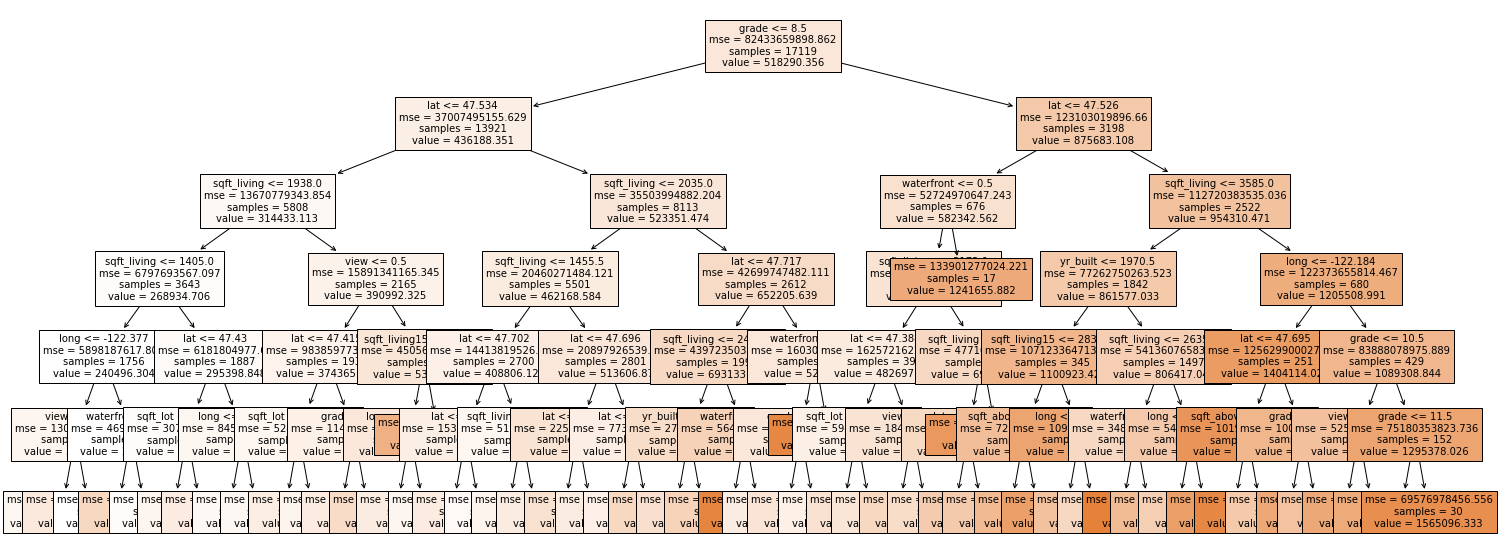

In [ ]:
# We can do a few runs with different max depth for the tree.
# Just change the value below and re-run this cell.
# The model versions you created will show up in the Vectice UI as new versions 
# of the "Regressor" Model. You can easily compare them from there.
tree_depth = 6

vectice.create_run("DT-Model", JobType.TRAINING)

vectice.start_run(inputs=[train_ds_version,test_ds_version,input_code])

dtr = DecisionTreeRegressor(max_depth=tree_depth, min_samples_split=50)
dtr.fit(X_train,y_train)
dtr_pred = dtr.predict(X_test) 

data_feature_names = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
                      'waterfront', 'view', 'condition', 'grade', 'sqft_above',
                      'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat',
                      'long', 'sqft_living15', 'sqft_lot15']

# Visualize the Decision Tree Model
plt.figure(figsize=(25, 10))
plot_tree(dtr, feature_names=data_feature_names, filled=True, fontsize=10)

MAE = mean_absolute_error(dtr_pred, y_test)
RMSE = sqrt(mean_squared_error(dtr_pred, y_test))

print("Root Mean Squared Error:", RMSE)
print("Mean Absolute Error:", MAE)

model_version = vectice.create_model_version().with_parent_name("Regressor").with_algorithm("Decision Tree").with_property("Tree Depth",str(tree_depth)).with_metric("RMSE",RMSE).with_metric("MAE",MAE).with_user_version(get_random_string(12))

vectice.end_run(outputs=[model_version])

### Random forest model

Let's use the Random Forest Regression and do some hyper-parameter tuning on it.

In [ ]:
# You can modify the parameters below and execute multiple runs to train 
# different versions of RF model.
nb_trees = 60
min_samples = 30

vectice.create_run("RF-Model", JobType.TRAINING)

vectice.start_run(inputs=[train_ds_version,test_ds_version,input_code])

rf_regressor = RandomForestRegressor(n_estimators=nb_trees, min_samples_leaf=min_samples)
rf_regressor.fit(X_train, y_train)
rf_regressor.score(X_test, y_test)
rf_regressor_pred = rf_regressor.predict(X_test)

MAE = mean_absolute_error(rf_regressor_pred, y_test)
RMSE = sqrt(mean_squared_error(rf_regressor_pred, y_test))

print("Root Mean Squared Error:", RMSE)
print("Mean Absolute Error:", MAE)

# Here's an alternative version to declare metrics
metrics = [("RMSE",RMSE),
           ("MAE",MAE)]

model_version = vectice.create_model_version().with_parent_name("Regressor").with_algorithm("Random Forest").with_property("nb_trees",str(nb_trees)).with_property("min_samples",str(min_samples)).with_metrics(metrics).with_user_version(get_random_string(12))

vectice.end_run(outputs=[model_version])


Root Mean Squared Error: 116061.40444042496
Mean Absolute Error: 73387.63712547845


2716

We can see that the Random Forest Regressor model gives the lowest error and should be the preferred approach despite the complexity of the algorithm. Let's get the list of features' importance to discuss which variables are influencing the model the most.

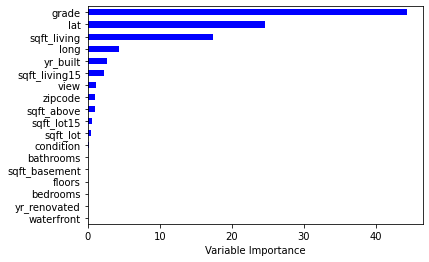

In [ ]:
columns = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
           'waterfront', 'view', 'condition', 'grade', 'sqft_above',
           'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat',
           'long', 'sqft_living15', 'sqft_lot15']

importance = pd.DataFrame({'Importance': rf_regressor.feature_importances_ * 100}, index=columns)
importance.sort_values(by="Importance", axis=0, ascending=True).plot(kind="barh", color="b")
plt.xlabel("Variable Importance")
plt.gca().legend_ = None


Thank you and congratulations! You have succesfully completed the notebook part of the tutorial.

In this notebooks we have illustrated how you can capture your experiments, hyper-parameters, dataset versions and metrics using Vectice SDK. 
You can now leverage Vectice UI for analysis, documentation and to engage a business conversation around the findings.

Vectice enables you to:
1. Make your experiments more reproducible.
2. Track the data and code that is used for each experiment and model versions.
3. Document your projects' progress and collaborate with your team in Vectice's UI.
4. Discover previous work and reuse your team knowledge for new projects.

We are constantly improving the Vectice SDK and the Vectice application. Let us know what improvements you would like to see in the solution and what your favorite features are after completing this tutorial. 

Feel free to explore more and come up with your own ideas on how to best start leveraging Vectice!
